In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

In [2]:
class GCN(nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()

        # convolutional layers
        num_hidden_features = 20
        self.conv0 = GCNConv(num_node_features, num_hidden_features)
        self.batch0 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch1 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch2 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch3 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv4 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch4 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv5 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch5 = nn.BatchNorm1d(num_hidden_features)
        
        self.conv6 = GCNConv(num_hidden_features, num_hidden_features)
        self.batch6 = nn.BatchNorm1d(num_hidden_features)

        # linear layers
        self.linear = nn.Linear(num_hidden_features, 4)

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.relu(x)
        x = self.batch0(x)
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.batch1(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.batch2(x)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.batch3(x)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.batch4(x)
        
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.batch5(x)
        
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = self.batch6(x)
        
        x = self.linear(x)

        return F.log_softmax(x, dim=1)
    
global activation_list
activation_list = {}

def get_activation(idx):
    '''Learned from: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6'''
    def hook(model, input, output):
        activation_list[idx] = output.detach()

    return hook

def register_hooks(model):
    # register hooks to extract activations
    model.conv0.register_forward_hook(get_activation('conv0'))
    model.conv1.register_forward_hook(get_activation('conv1'))
    model.conv2.register_forward_hook(get_activation('conv2'))
    model.conv3.register_forward_hook(get_activation('conv3'))
    model.conv4.register_forward_hook(get_activation('conv4'))
    model.conv5.register_forward_hook(get_activation('conv5'))
    model.conv6.register_forward_hook(get_activation('conv6'))
    
    return model

In [3]:
def save_checkpoint(model, optimizer, method, num_epochs=-1, isbest=False, cg_dict=None):
    """Save pytorch model checkpoint.
    Args:
        - model         : The PyTorch model to save.
        - optimizer     : The optimizer used to train the model.
        - args          : A dict of meta-data about the model.
        - num_epochs    : Number of training epochs.
        - isbest        : True if the model has the highest accuracy so far.
        - cg_dict       : A dictionary of the sampled computation graphs.
    """
    filename = "../../benchmarks/gnn-model-explainer-master/ckpt/syn1_base_h20_o20.pth.tar"
    torch.save(
        {
            "epoch": num_epochs,
            "model_type": method,
            "optimizer": optimizer,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "cg": cg_dict,
        },
        filename,
    )

In [4]:
def test(model, node_data_x, node_data_y, edge_list, mask):
    # enter evaluation mode
    model.eval()

    correct = 0
    pred = model(node_data_x, edge_list).max(dim=1)[1]

    correct += pred[mask].eq(node_data_y[mask]).sum().item()
    return correct / (len(node_data_y[mask]))

def train(model, optimizer, features, labels, edges, plot=False, save=False):
    # register hooks to track activation
    model = register_hooks(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    # list of accuracies
    train_accuracies, test_accuracies = list(), list()

    node_data_x = torch.from_numpy(features).float()
    node_data_y = torch.from_numpy(labels)
    edge_list = torch.from_numpy(edges).transpose(0, 1)

    train_size = 0.80
    train_mask = np.random.rand(len(node_data_x)) < train_size
    test_mask = ~train_mask
    
    predictions = []
    
    # epochs
    for epoch in range(1500):
            # set mode to training
            model.train()
            optimizer.zero_grad()

            # input data
            out = model(node_data_x, edge_list)
            predictions += out.cpu().detach().numpy().tolist()

            # calculate loss
            loss = F.nll_loss(out[train_mask], node_data_y[train_mask])
            loss.backward()
            optimizer.step()

            # get accuracy
            train_acc = test(model, node_data_x, node_data_y, edge_list, train_mask)
            test_acc = test(model, node_data_x, node_data_y, edge_list, test_mask)

            ## add to list and print
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc), end = "\r")

    # plut accuracy graph
    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()
        
    if save:
        torch.save(model.state_dict(), "models/ba_shape_model.pkl")
        
        with open("models/ba_shape_activation.txt", 'wb') as file:
            pickle.dump(activation_list, file)
            
    cg_dict = {
        "adj": np.array(nx.to_numpy_matrix(G)),
        "feat": features,
        "label": [labels],
        "pred": np.expand_dims(predictions, axis=0),
        "train_idx": list(range(len(node_data_x))),
    }
    
    args = "base"
            
    save_checkpoint(model, optimizer, args, 1500, True, cg_dict=cg_dict)

In [5]:
def load_data():
    G = nx.readwrite.read_gpickle("../../data/synthetic/graph_ba_300_80.gpickel")
    role_ids = np.load("../../data/synthetic/role_ids_ba_300_80.npy")

    return G, role_ids

def preprocess_input_graph(G):
    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].size
    features = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        features[i, :] = G.nodes[u]["feat"]
    
    edges = np.array(G.edges)

    return features, edges

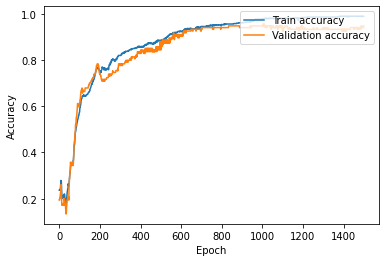

In [6]:
G, labels = load_data()
features, edges = preprocess_input_graph(G)
model = GCN(features.shape[1])

load_pretrained = False

if load_pretrained:
    model.load_state_dict(torch.load("models/ba_shape_model.pkl"))
    model.eval()
    
    print(model)

    with open("models/ba_shape_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())
        
else:
    train(model, G, features, labels, edges, plot=True, save=True)

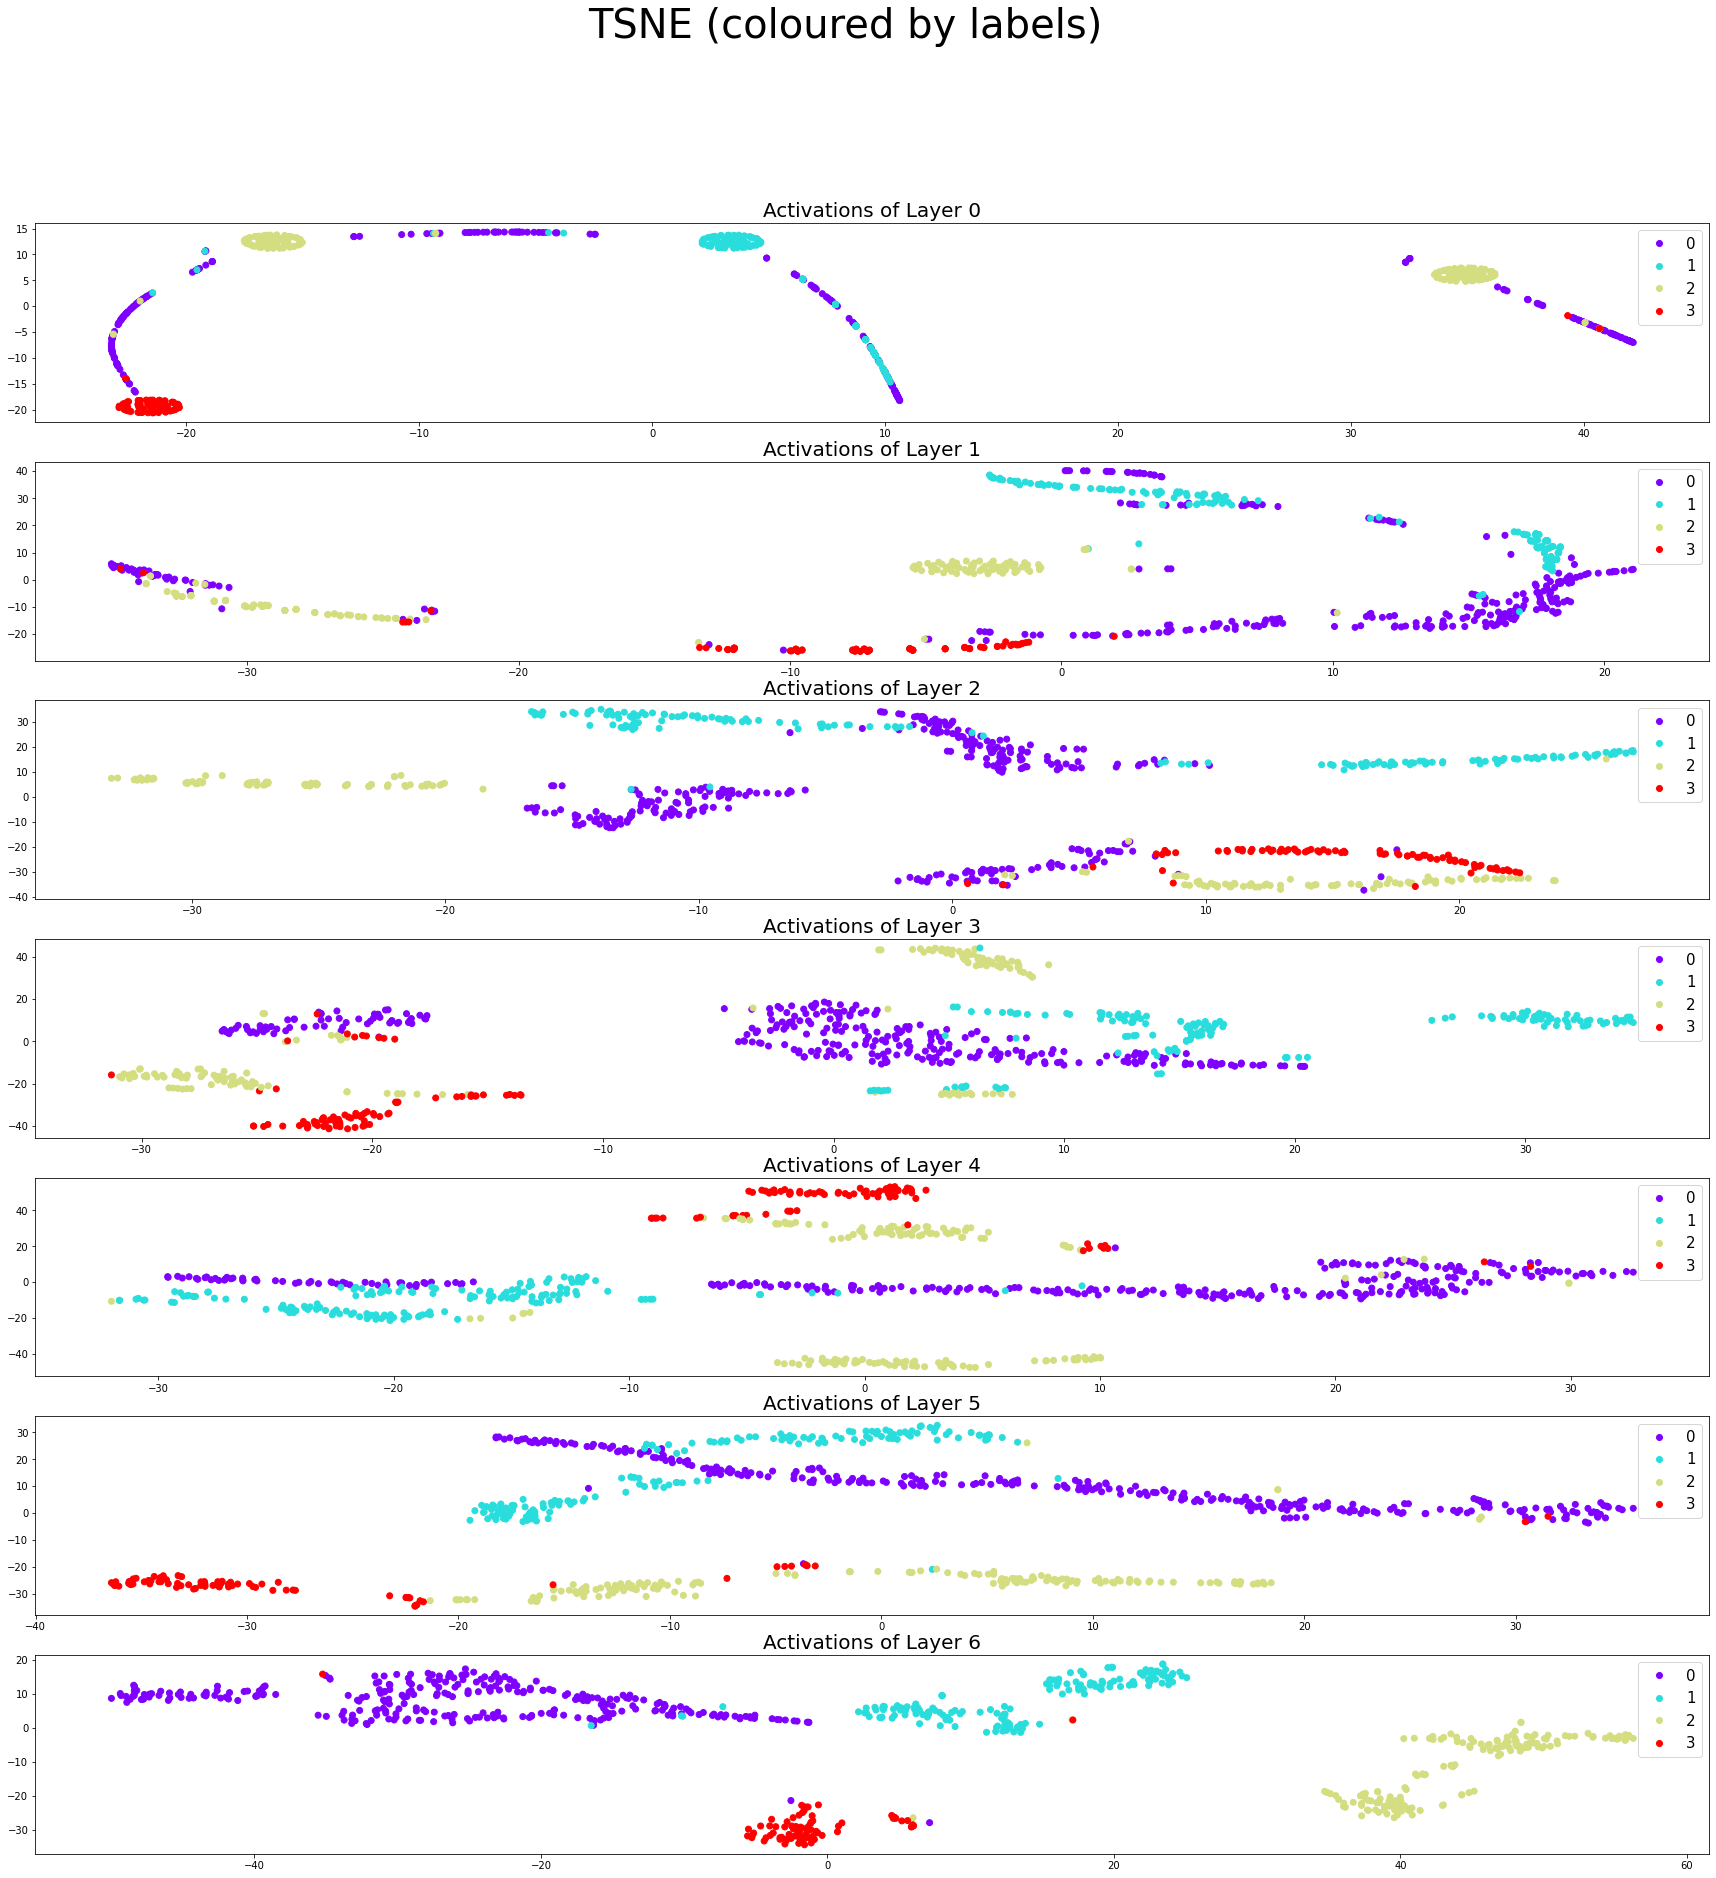

In [7]:
### Analysis
num_layers = len(activation_list)

def plot_activation_space(data, labels, activation_type):
    fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
    fig.suptitle(f'{activation_type} (coloured by labels)', fontsize=40)

    counter = 0
    for ax in axs:
        item = data[counter]
        ax.set_title("Activations of Layer {}".format(counter), fontsize=20)
        scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
        ax.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)), fontsize=15)
        counter += 1
            

# TSNE conversion
tsne_data = []
for i in range(0, num_layers):
    tsne_data.append(TSNE(n_components=2).fit_transform(activation_list[f'conv{i}']))
    
# plot tsne graphs
plot_activation_space(tsne_data, labels, "TSNE")

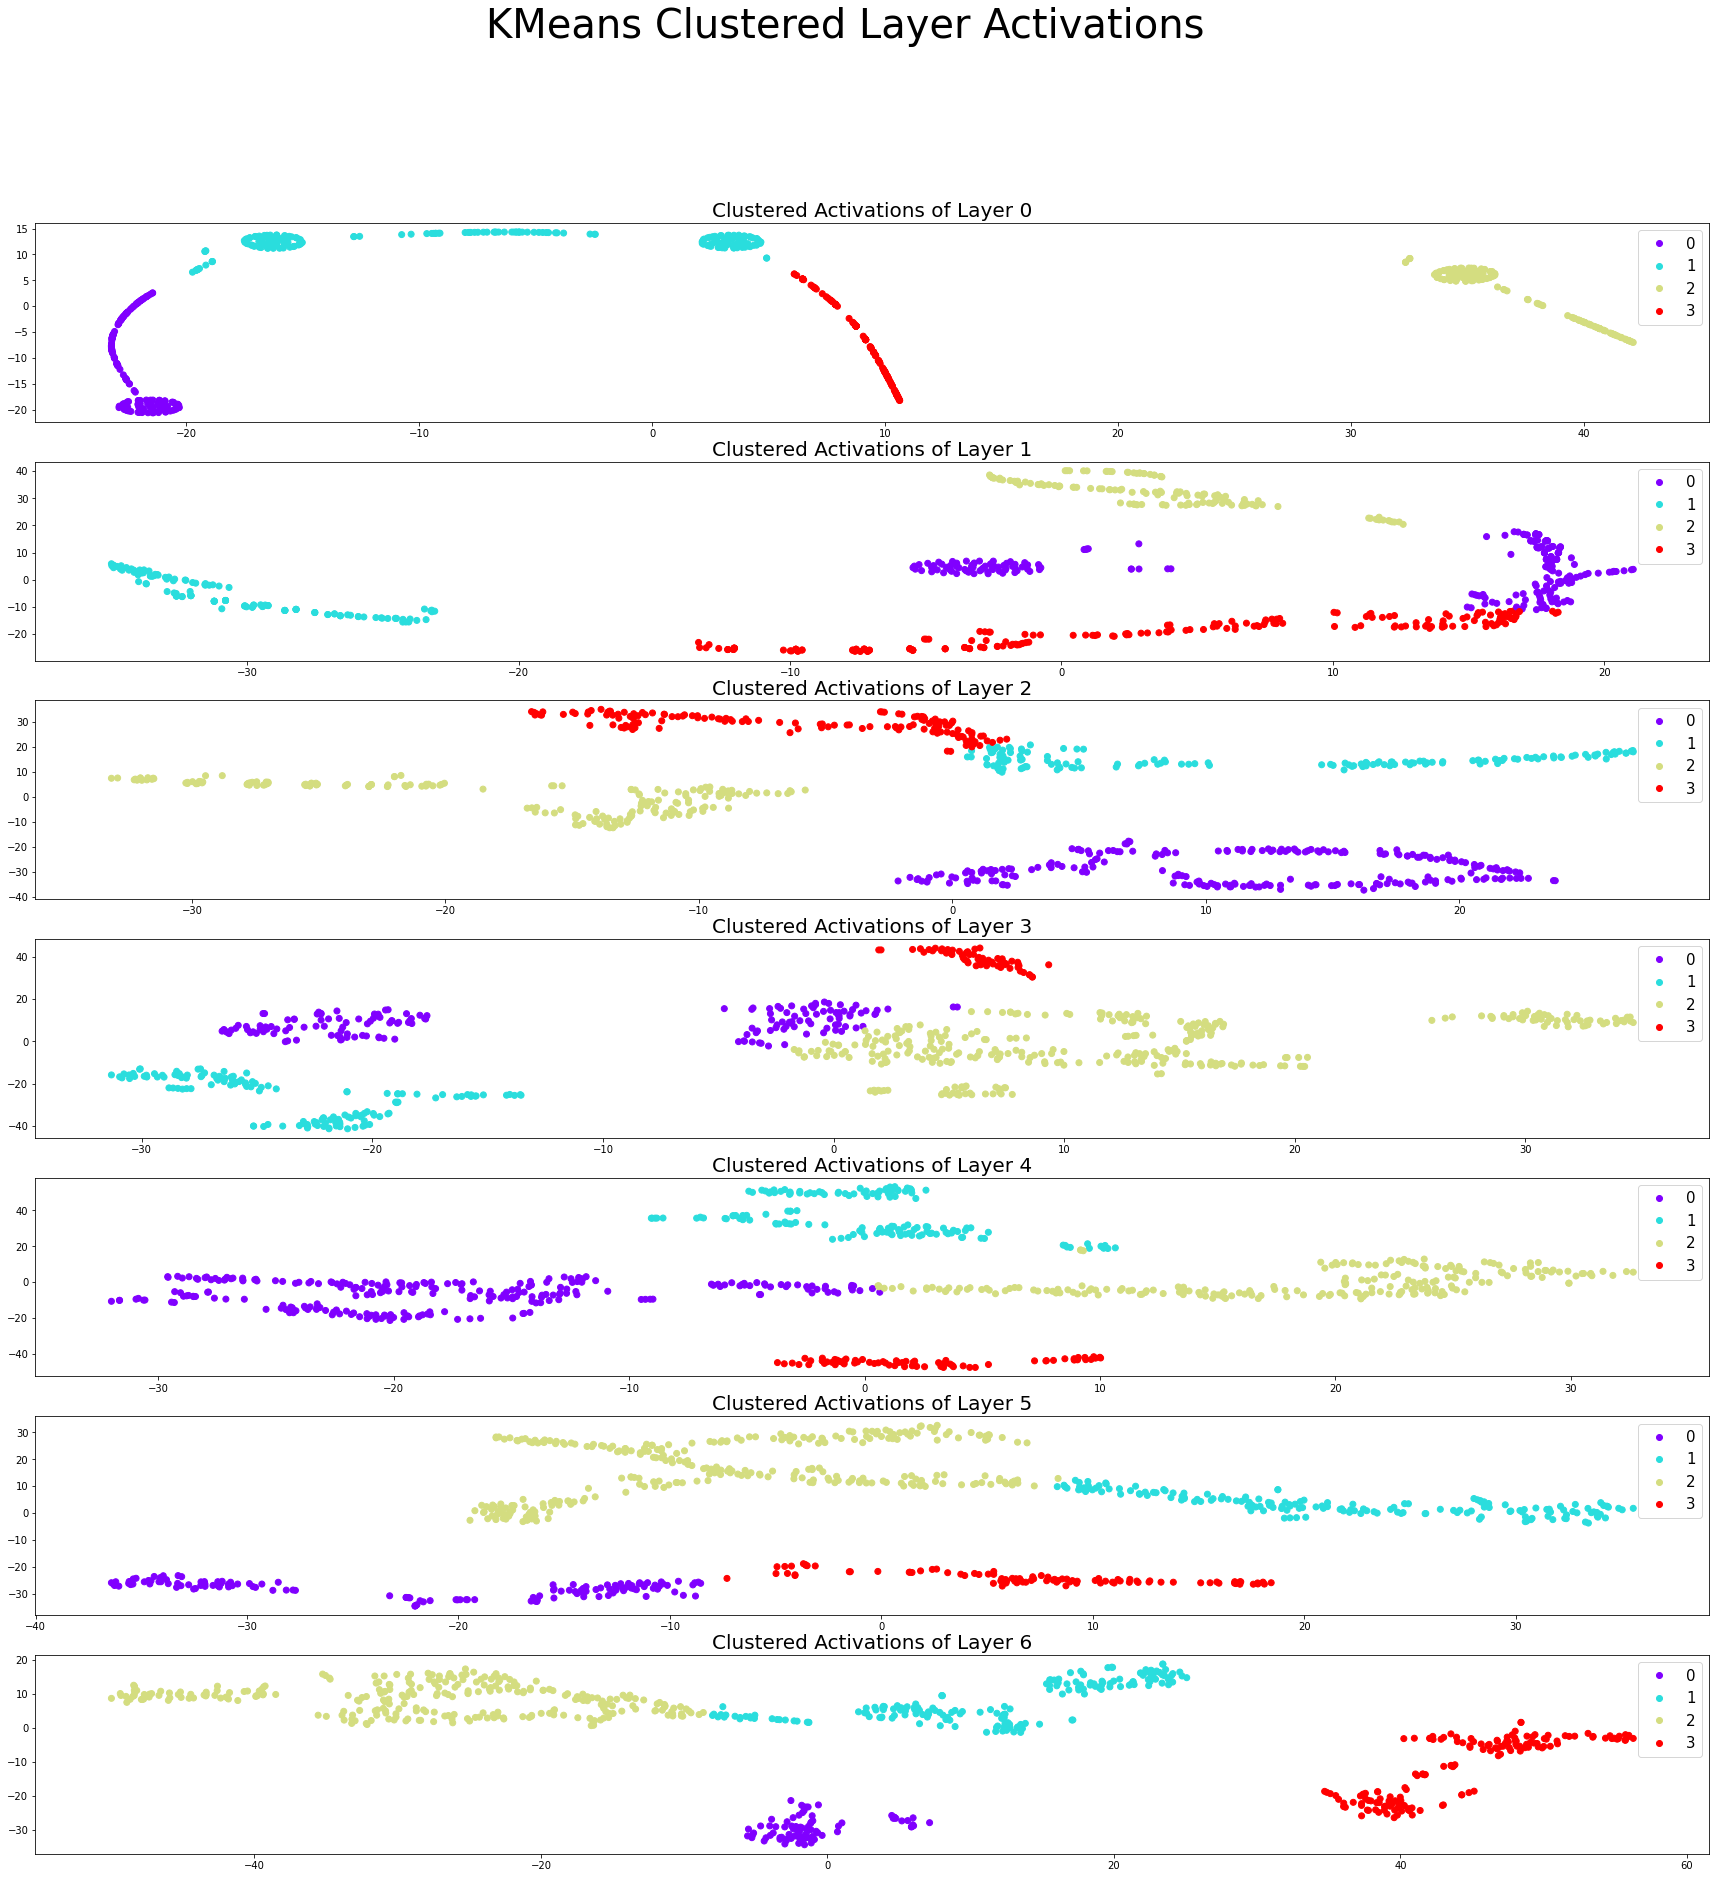

In [8]:
### Perform clustering

def plot_clusters(data, clustering_type):
    fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
    fig.suptitle(f'{clustering_type} Clustered Layer Activations', fontsize=40)

    counter = 0
    for ax in axs:
        labels, item = data[counter]
        ax.set_title("Clustered Activations of Layer {}".format(counter), fontsize=20)
        scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
        l = list(np.unique(labels))
        ax.legend(handles=scatter.legend_elements()[0], labels=l, fontsize=15)
        counter += 1

k = 4
kmeans_models = []
kmeans_data = []
for item in tsne_data:
    model = KMeans(n_clusters=k, random_state=0)
    kmeans = model.fit(item)
    kmeans_models.append(kmeans)
    kmeans_data.append((kmeans.labels_, item))

plot_clusters(kmeans_data, "KMeans")

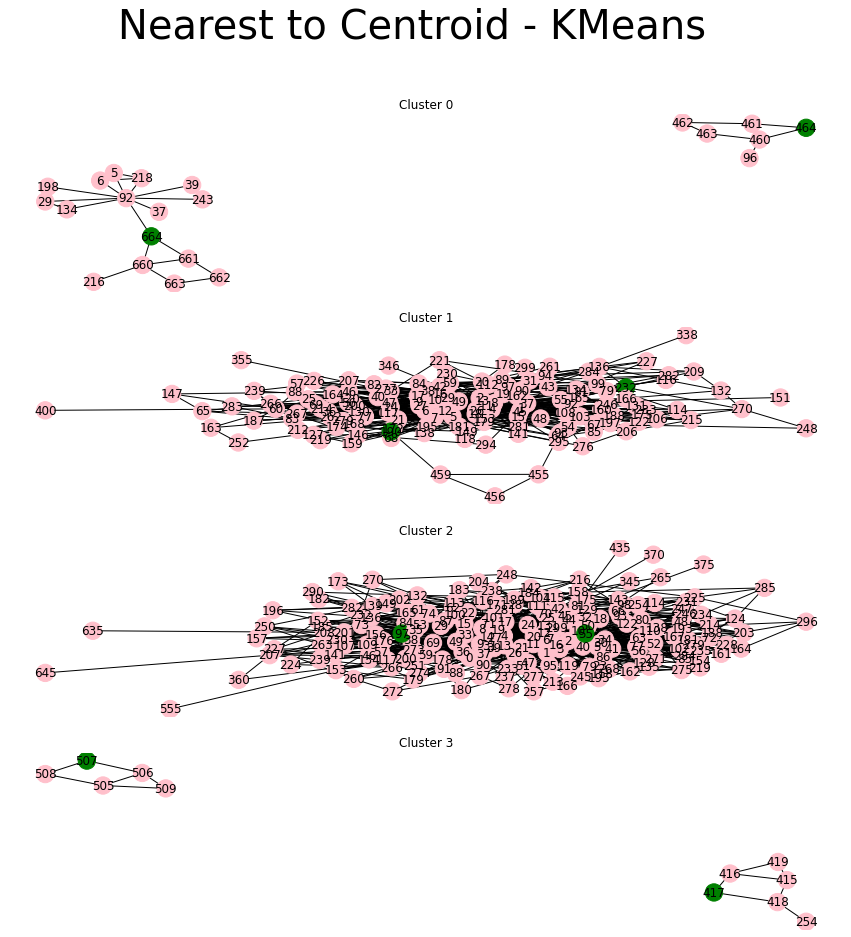

In [9]:
# 1) get 3 closest nodes of a cluster

def plot_samples(model, data, df, clustering_type):
    fig, axes = plt.subplots(k, 1, figsize=(15,15))
    fig.suptitle(f'Nearest to Centroid - {clustering_type}', fontsize=40)

    l = list(range(0, k))

    for i, ax in zip(l, axes):
        # get distance of nodes
        distances = model.transform(data)[:, i]
        top_indices = np.argsort(distances)[::][:2]

        # visualise
        ax.set_title(f"Cluster {i}")

        # get 3 step neighbours
        neighbours = list(top_indices)
        num_expansions = 2

        for i in range(0, num_expansions):
            new_neighbours = list()
            for e in edges:
                if (e[0] in neighbours) or (e[1] in neighbours):
                    new_neighbours.append(e[0])
                    new_neighbours.append(e[1])

            neighbours = neighbours + new_neighbours
            neighbours = list(set(neighbours))

        new_G = nx.Graph()
        df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
        remaining_edges = df_neighbours.to_numpy()
        new_G.add_edges_from(remaining_edges)

        color_map = []
        for node in new_G:
            if node in top_indices:
                color_map.append('green')
            else: 
                color_map.append('pink')

        nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)

    plt.savefig("output/4clusters.png")
    plt.show()

model = kmeans_models[5]
data = tsne_data[5]
df = pd.DataFrame(edges)
plot_samples(model, data, df, "KMeans")

In [ ]:
### Perform clustering
meanshift_models = []
meanshift_data = []
for item in tsne_data:
    model = MeanShift()
    meanshift = model.fit(item)
    meanshift_models.append(meanshift)
    meanshift_data.append((meanshift.labels_, item))

plot_clusters(meanshift_data, "Mean Shift")

In [ ]:
### Perform clustering
dbscan_models = []
dbscan_data = []
for item in tsne_data:
    model = DBSCAN(eps=3, min_samples=2)
    dbscan = model.fit(item)
    dbscan_models.append(dbscan)
    dbscan_data.append((dbscan.labels_, item))

plot_clusters(meanshift_data, "Mean Shift")